In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from nltk.corpus import stopwords

%matplotlib inline

pd.set_option('display.max_columns', 100)

# Dataset and parsing/cleaning of data

In [2]:
data = pd.read_csv('mycareersfuture_master.csv')

In [3]:
# Parse the salary columns

# Remove dollar sign and comma
for col in ['SalaryLower', 'SalaryUpper']:
    data[col] = [re.sub('[$,]', '', text) for text in data[col]]
    
# Extracting the text and placing into a new column 'SalaryType
data['SalaryType'] = data['SalaryUpper'].apply(lambda x: re.search('\D+', x).group())

# Extracting only the numerical value for the SalaryUpper column
data['SalaryUpper'] = data['SalaryUpper'].apply(lambda x: re.match('\d*', x).group())

# Replacing the text 'Salary undisclosed' with NaN
data[['SalaryLower', 'SalaryType']] = data[['SalaryLower', 'SalaryType']].replace('Salary undisclosed', np.nan)

# Replacing '' in SalaryUpper with NaN
data['SalaryUpper'] = data['SalaryUpper'].replace('', np.nan)

# Set the salary columns to numeric
data[['SalaryLower', 'SalaryUpper']] = data[['SalaryLower', 'SalaryUpper']].astype('float32')

# Convert the annual salary data into monthly salary data
data.loc[data['SalaryType']=='Annually', ['SalaryLower', 'SalaryUpper']] = \
data[data['SalaryType']=='Annually'][['SalaryLower', 'SalaryUpper']].apply(lambda x: x/12)

# Update the SalaryType to monthly
data.loc[data['SalaryType']=='Annually', 'SalaryType'] = 'Monthly'

# Create SalaryMean which is the mean of SalaryLower and SalaryUpper
data['SalaryMean'] = (data['SalaryLower'] + data['SalaryUpper']) / 2.

In [4]:
data['EmploymentType'].value_counts()

# Exclude all those job listings that are temporary, freelance, internship

Full Time                                                            252
Contract, Full Time                                                  151
Permanent, Full Time                                                 125
Permanent                                                            125
Contract                                                              78
Permanent, Contract                                                   12
Permanent, Contract, Full Time                                         8
Temporary                                                              4
Freelance                                                              4
Internship                                                             3
Part Time, Contract, Flexi work                                        2
Freelance, Flexi work                                                  2
Part Time, Contract                                                    1
Part Time, Permanent, Temporary, Contract, Flexi wo

In [5]:
# Create a list of those Employment Types to drop
emp_type_list = data['EmploymentType'].value_counts().index[7::]

# Iterate through each Employment Type and exclude them
for emp_type in emp_type_list:
    data = data[data['EmploymentType'] != emp_type].copy()

In [6]:
# Combine RoleDesc and Requirements
data['JD'] = data['RoleDesc'] + ' ' + data['Requirements']

In [7]:
# Parse dummy variables for columns, JobCategories, EmploymentType, Seniority
col_list = ['JobCategories', 'EmploymentType', 'Seniority']

for col in col_list:
    value_list = data[col].unique()
    value_list = [value.split(',') for value in value_list]
    value_list = list(itertools.chain(*value_list))
    value_list = [str.strip(value) for value in value_list]
    value_list = np.unique(value_list)
    
    # Create dummy variables for the column
    for value in value_list:
        data.loc[data[col].str.contains(value), value] = 1
        
    # Replace NaN with zero
    data[value_list] = data[value_list].fillna(value=0)
    

## Question 1

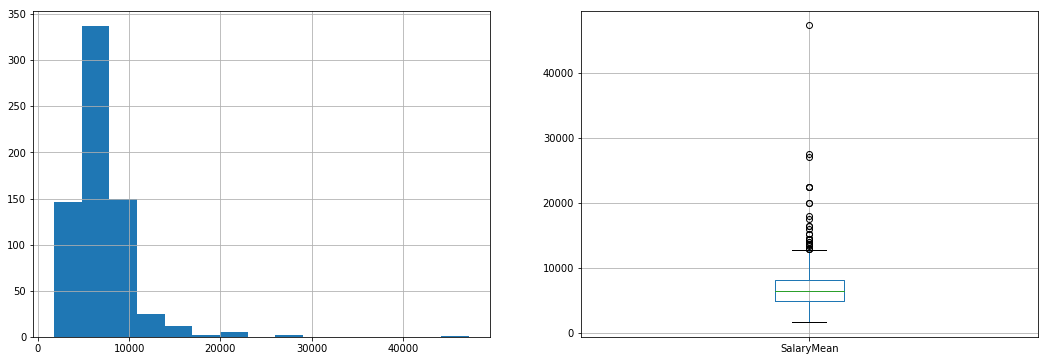

In [8]:
# Look at the distribution of SalaryMean
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
data['SalaryMean'].hist(ax=ax1, bins=15)
ax2 = fig.add_subplot(122)
data.boxplot(column='SalaryMean', ax=ax2)

# There appears to be many outliers with very high salary levels

In [9]:
# Calculating the Inter-Quartile Range and the median in order to exclude outliers

iqr = np.percentile(data[~data['SalaryMean'].isnull()]['SalaryMean'], 75) - \
np.percentile(data[~data['SalaryMean'].isnull()]['SalaryMean'], 25)

sal_median = np.percentile(data[~data['SalaryMean'].isnull()]['SalaryMean'], 50)

print iqr, sal_median

3125.0 6500.0


In [10]:
# Copy into a new dataframe the rows whereby salary is not null and also not an outlier (greater than 1.5 IQR)
data2 = data[(~data['SalaryMean'].isnull()) & (data['SalaryMean']<=(1.5*iqr+sal_median))].copy()

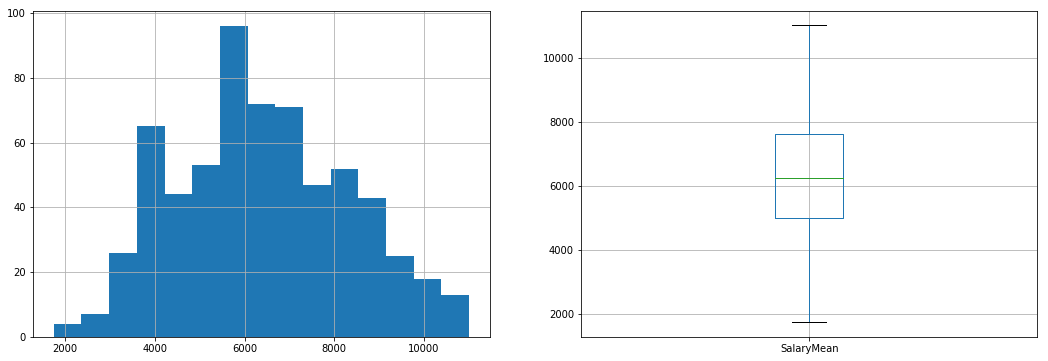

In [11]:
# Check the distribution of SalaryMean
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
data2['SalaryMean'].hist(ax=ax1, bins=15)
ax2 = fig.add_subplot(122)
data2.boxplot(column='SalaryMean', ax=ax2)

# The distribution looks better now

In [12]:
# Create the classification label - 1 for salary above median and 0 for equal and below
data2['SalaryLabel'] = data2['SalaryMean'].apply(lambda x: 1 if x > data2['SalaryMean'].median() else 0)

In [13]:
# check correlation of dummy variables with target

sector_var = pd.concat([data2.iloc[:,15:47].copy(), data2['SalaryLabel']], axis=1)
emptype_var = pd.concat([data2.iloc[:,47:50].copy(), data2['SalaryLabel']], axis=1)
senior_var = pd.concat([data2.iloc[:,50::].copy(), data2['SalaryLabel']], axis=1)

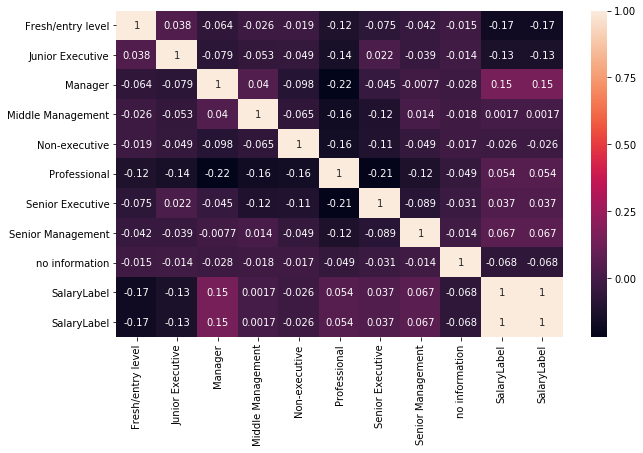

In [14]:
fig = plt.figure(figsize=(10,6))
sns.heatmap(senior_var.corr(), annot=True)

# the seniority features have little correlation with the target variable SalaryLabel

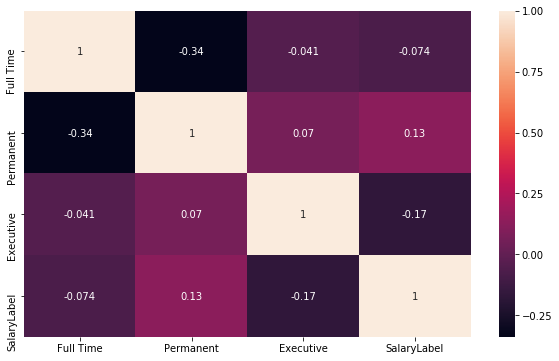

In [15]:
fig = plt.figure(figsize=(10,6))
sns.heatmap(emptype_var.corr(), annot=True)

# the EmploymentType features have little correlation with the target variable SalaryLabel

In [16]:
sector_corr = sector_var.corr()
print sector_corr.iloc[:, -1]

# the sector features have little correlation with the target variable SalaryLabel

Admin / Secretarial                 -0.055813
Advertising / Media                 -0.011226
Banking and Finance                  0.039272
Building and Construction            0.000500
Consulting                          -0.032957
Customer Service                    -0.104832
Design                              -0.022515
Education and Training              -0.099394
Engineering                         -0.030246
Environment / Health                 0.000353
Events / Promotions                       NaN
F&B                                  0.141577
General Management                  -0.031917
Healthcare / Pharmaceutical          0.080058
Human Resources                      0.069277
Information Technology              -0.028631
Insurance                           -0.059469
Logistics / Supply Chain             0.028927
Manufacturing                       -0.017244
Marketing / Public Relations         0.000795
Others                               0.055975
Personal Care / Beauty            

Since the other features are not highly correlated to the salary classification labels, will use only the job description and job requirements.

In [17]:
# Setting up the predictor and target variables
x = data2['JD'].copy()
y = data2['SalaryLabel'].copy()

In [18]:
# Splitting the data into train and test groups
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=29)

## Try first model of LogisticRegression to predict if the salary of a job posting will be above median or below median  
Start with Logistic Regression as it is a simple classification model

In [19]:
# First model of Logistic Regression

# Count vectorise the x_train which is job description and job requirements
cvt = CountVectorizer(ngram_range=(1,4))
tokens_train = pd.DataFrame(cvt.fit_transform(x_train).todense(), columns=cvt.get_feature_names())

# Count vectorise the x_test using the same trained CountVectorizer
tokens_test = pd.DataFrame(cvt.transform(x_test).todense(), columns=cvt.get_feature_names())

lr = LogisticRegression(random_state=29)
lr.fit(tokens_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=29, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
# Cross-validate the Logistic Regression model
scores = cross_val_score(lr, tokens_train, y_train, cv=5, n_jobs=-1, verbose=1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(lr.score(tokens_test, y_test)))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.1s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Cross validation score: [0.68888889 0.67777778 0.64044944 0.61363636 0.67045455]
Mean score: 0.658241402792
Score on test data: 0.659685863874


In [21]:
# Extract the coefficients of the Logistic Regression against the tokens
lr_coef = pd.DataFrame({'tokens':tokens_train.columns, 'lr_coef':lr.coef_[0]})

In [22]:
# Sort the tokens by descending order of the regression coefficients
lr_coef = lr_coef.sort_values(by='lr_coef', axis=0, ascending=False)

# Identify the top 20 features which are most important to predict the classification of salary above median
lr_coef.head(20)

,lr_coef,tokens
187428,0.254700,sr
187432,0.243766,sr associate
123754,0.180030,managers
151630,0.178798,phd
173483,0.175271,risk
39834,0.168723,by
84541,0.163533,for
220118,0.161043,users minimum
209352,0.161043,to business users minimum
220119,0.161043,users minimum diploma


The top few tokens like "sr" for senior, senior associate, managers make sense in predicting higher salaries as they are for more experienced positions, "phd" also makes sense as jobs that require higher qualifications normally pay more. However it is surprising to have words like "by" and "for" that show up in the top 20 features

In [23]:
print(classification_report(y_test, lr.predict(tokens_test), labels=[0,1], target_names=['Below Median', 'Above Median']))

# The model predicts reasonably well at f1-score of 0.66 though it's not fantastic for a simple 2 class model

              precision    recall  f1-score   support

Below Median       0.61      0.70      0.66        88
Above Median       0.71      0.62      0.66       103

 avg / total       0.67      0.66      0.66       191



In [24]:
# Tuning of LogisticRegression model for better results
params = {
    'C' : [0.2, 0.6, 1.0],
    'solver' : ['newton-cg', 'lbfgs', 'sag']
}

lr_gs = GridSearchCV(lr, param_grid=params, cv=3, n_jobs=-1, verbose=1)
lr_gs.fit(tokens_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 19.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=29, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.2, 0.6, 1.0], 'solver': ['newton-cg', 'lbfgs', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [25]:
print(lr_gs.best_params_)
print(lr_gs.best_score_)

{'C': 0.2, 'solver': 'newton-cg'}
0.6539325842696629


In [39]:
# Score test data with tuned parameters 
lr2 = LogisticRegression(C=lr_gs.best_params_['C'], solver=lr_gs.best_params_['solver'], random_state=29)
lr2.fit(tokens_train, y_train)

# Score on test data
print('Score on test data: {}'.format(lr2.score(tokens_test, y_test)))

Score on test data: 0.664921465969


In [40]:
print(classification_report(y_test, lr2.predict(tokens_test), labels=[0,1], target_names=['Below Median', 'Above Median']))

# F1 score only improved marginally for Below Median class

              precision    recall  f1-score   support

Below Median       0.62      0.73      0.67        88
Above Median       0.72      0.61      0.66       103

 avg / total       0.67      0.66      0.66       191



In [30]:
# Second model of RandomForest
rfc = RandomForestClassifier(n_jobs=-1, random_state=29, verbose=1)
rfc.fit(tokens_train, y_train)


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=29, verbose=1, warm_start=False)

In [31]:
# Cross-validate the RandomForest model
scores = cross_val_score(rfc, tokens_train, y_train, cv=5, n_jobs=-1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(rfc.score(tokens_test, y_test)))


Cross validation score: [0.65555556 0.66666667 0.69662921 0.55681818 0.63636364]
Mean score: 0.642406650777
Score on test data: 0.570680628272


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [32]:
print(classification_report(y_test, rfc.predict(tokens_test), labels=[0,1], target_names=['Below Median', 'Above Median']))

# The random forest classifier performs even worse than Logistic Regression in predicting above median salaries. Probably
# some pruning of the decision trees is required to improve the performance.

              precision    recall  f1-score   support

Below Median       0.52      0.82      0.64        88
Above Median       0.70      0.36      0.47       103

 avg / total       0.62      0.57      0.55       191



[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [41]:
# Tuning of RandomForest model for better results
params = {
    'n_estimators' : range(1, 11, 2),
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 2, 3, None]
}

rf_gs = GridSearchCV(rfc, param_grid=params, cv=3, n_jobs=-1, verbose=1)
rf_gs.fit(tokens_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=-1,
            oob_score=False, random_state=29, verbose=1, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 3, 5, 7, 9], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [42]:
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'n_estimators': 7, 'criterion': 'gini', 'max_depth': 3}
0.6179775280898876


In [43]:
# Score test data with tuned parameters 
rfc2 = RandomForestClassifier(n_estimators=rf_gs.best_params_['n_estimators'], \
                              criterion=rf_gs.best_params_['criterion'], \
                              max_depth=rf_gs.best_params_['max_depth'], n_jobs=-1, random_state=29, verbose=1)
rfc2.fit(tokens_train, y_train)

print('Score on test data: {}'.format(rfc2.score(tokens_test, y_test)))

# Accuracy improved slightly to be almost the same as Logistic Regression

[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.0s finished


Score on test data: 0.544502617801


[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished


In [44]:
print(classification_report(y_test, rfc2.predict(tokens_test), labels=[0,1], target_names=['Below Median', 'Above Median']))


              precision    recall  f1-score   support

Below Median       0.50      0.77      0.61        88
Above Median       0.64      0.35      0.45       103

 avg / total       0.58      0.54      0.53       191



[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished


## Question 2
Set up the target variable as IT sector versus non-IT sector jobs and build a classification model  
to predict it

In [ ]:
# Set up y variable to the binary column "Information Technology"
x2 = data['JD'].copy()
y2 = data['Information Technology'].copy()

In [ ]:
# Split the data into train and test
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=29)

In [ ]:
# Tokenise the x2_train
cvt2 = CountVectorizer(ngram_range=(1,4))
tokens2_train = pd.DataFrame(cvt2.fit_transform(x2_train).todense(), columns=cvt2.get_feature_names())

# Tokenise the x2_test using the same trained CountVectorizer
tokens2_test = pd.DataFrame(cvt2.transform(x2_test).todense(), columns=cvt2.get_feature_names())

lr2 = LogisticRegression(random_state=29)
lr2.fit(tokens2_train, y2_train)

In [ ]:
# Cross-validate the Logistic Regression model
scores = cross_val_score(lr2, tokens2_train, y2_train, cv=5, n_jobs=-1, verbose=1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(lr2.score(tokens2_test, y2_test)))

In [ ]:
print(classification_report(y2_test, lr2.predict(tokens2_test), labels=[0,1], target_names=['Non-IT sector', 'IT sector']))


In [ ]:
# Try RandomForestClassifier to compare the performance

rfc2 = RandomForestClassifier(n_jobs=-1, random_state=29, verbose=1)
rfc2.fit(tokens2_train, y2_train)

In [ ]:
# Cross-validate the RandomForest model
scores = cross_val_score(rfc2, tokens2_train, y2_train, cv=5, n_jobs=-1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(rfc2.score(tokens2_test, y2_test)))


In [ ]:
print(classification_report(y2_test, rfc2.predict(tokens2_test), labels=[0,1], target_names=['Non-IT sector', 'IT sector']))
